In [10]:
from pathlib import Path

project_dir = Path('.').absolute().parent
project_dir

PosixPath('/home/dtch1997/github/mcx-lab/rl-baselines3-zoo')

# Inspect logged inputs / outputs

Logs generated with `scripts/enjoy_with_logging.py`

In [11]:
import numpy as np
import pickle 
import json

def load_robot_states(stats_dir):
    base_rpy = np.load(stats_dir / 'base_rpy.npy')
    base_position = np.load(stats_dir / 'base_position.npy')
    base_velocity = np.load(stats_dir / 'base_velocity.npy')
    motor_position = np.load(stats_dir / 'motor_position.npy')
    motor_velocity = np.load(stats_dir / 'motor_velocity.npy')
    ref_displacement = np.load(stats_dir / 'reference_displacement.npy')
    act_displacement = np.load(stats_dir / 'actual_displacement.npy')
    ref_foot_contacts = np.load(stats_dir / 'reference_foot_contact.npy')
    act_foot_contacts = np.load(stats_dir / 'actual_foot_contact.npy')
    nn_observations = np.load(stats_dir / 'nn_observations.npy')

    reward_component_values = np.load(stats_dir / 'reward_components.npy')
    with open(stats_dir / 'reward_component_names.json', 'r') as file:
        reward_component_names = json.load(file)
    print(nn_observations.shape)
    nn_actions = np.load(stats_dir / 'nn_actions.npy')
    time = np.load(stats_dir / 'time.npy')
    
    return {
        'time': time, 
        'base_rpy': base_rpy,
        'base_pos': base_position,
        'base_vel': base_velocity,
        'motor_pos': motor_position, 
        'motor_vel': motor_velocity, 
        'ref_displacement': ref_displacement,
        'act_displacement': act_displacement,
        'ref_foot_contacts': ref_foot_contacts, 
        'act_foot_contacts': act_foot_contacts, 
        'nn_obs': nn_observations,
        'nn_act': nn_actions,
        'reward_component_values': reward_component_values,
        'reward_component_names': reward_component_names
    }

def load_normalizer(model_dir):
    with open(model_dir / 'A1GymEnv-v0' / 'vecnormalize.pkl', 'rb') as file:
        normalizer = pickle.load(file)
    return normalizer

In [12]:
log_dir = project_dir / 'logs' / 'ppo' 
foot_names = ['FR', 'FL', 'RR', 'RL']

stats_dirs = [
    log_dir / 'A1GymEnv-v0_44' / 'stats',
    log_dir / 'A1GymEnv-v0_55' / 'stats'
]

main_stats = load_robot_states(stats_dirs[0])
baseline_stats = load_robot_states(stats_dirs[1])

(2000, 1, 108)
(1000, 1, 88)


# Plot Reference / Actual Foot Contacts

In [17]:
import matplotlib.pyplot as plt

google_blue = (66 / 256, 133 / 256, 244 / 256, 1)
google_red = (219 / 256, 68 / 256, 55 / 256, 1)
google_yellow = (244 / 256, 180 / 256, 0, 1)
google_green = (15 / 256, 157 / 256, 88 / 256, 1)

foot_names = ['FR', 'FL', 'RR', 'RL']
foot_colors = [google_blue, google_red, google_yellow, google_green]

def plot_foot_contacts(ax, time, foot_contacts, title):
    foot_contacts = 2 * (foot_contacts > 0) - 1
    ax.set_yticks([0,1,2,3])
    ax.set_yticklabels(foot_names)
    for i in range(4):
        # Select timesteps where foot is on ground
        ground_idx = foot_contacts[:,i] == 1
        ax.set_title(title)
        ax.axhline(y=i+0.5, color='black', linestyle='--')
        ax.fill_between(time, i-0.3, i+0.3, where=ground_idx, color = foot_colors[i])


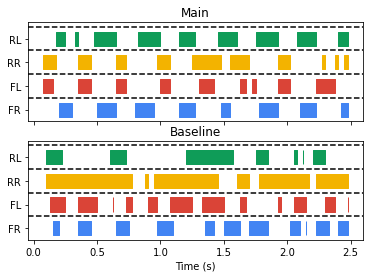

In [25]:
NUM_TIMESTEPS = 100

main_time = main_stats['time'][:NUM_TIMESTEPS]
main_act_foot_contacts = main_stats['act_foot_contacts'][:NUM_TIMESTEPS]

baseline_time = baseline_stats['time'][:NUM_TIMESTEPS]
baseline_act_foot_contacts = baseline_stats['act_foot_contacts'][:NUM_TIMESTEPS]

fig, ax = plt.subplots(2, sharex = True)
plot_foot_contacts(ax[0], main_time, main_act_foot_contacts, "Main")
plot_foot_contacts(ax[1], baseline_time, baseline_act_foot_contacts, "Baseline")
ax[1].set_xlabel("Time (s)")
plt.savefig("cpg_vs_no_cpg.png")

In [34]:
import matplotlib.pyplot as plt

google_blue = (66 / 256, 133 / 256, 244 / 256, 1)
google_red = (219 / 256, 68 / 256, 55 / 256, 1)
google_yellow = (244 / 256, 180 / 256, 0, 1)
google_green = (15 / 256, 157 / 256, 88 / 256, 1)

foot_names = ['FR', 'FL', 'RR', 'RL']
foot_colors = [google_blue, google_red, google_yellow, google_green]

def plot_foot_contacts(ax, time, foot_contacts, title):
    foot_contacts = 2 * (foot_contacts > 0) - 1
    ax.set_yticks([0,1,2,3])
    ax.set_yticklabels(foot_names)
    for i in range(4):
        # Select timesteps where foot is on ground
        ax.set_title(title)
        ax.axhline(y=i+0.5, color='black', linestyle='--')
        ax.plot(i + foot_contacts[:,i] * 0.35)


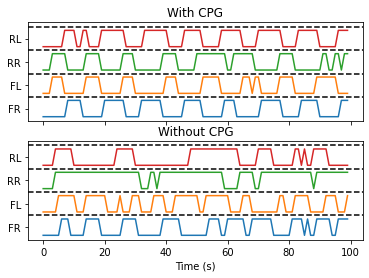

In [35]:
NUM_TIMESTEPS = 100

main_time = main_stats['time'][:NUM_TIMESTEPS]
main_act_foot_contacts = main_stats['act_foot_contacts'][:NUM_TIMESTEPS]

baseline_time = baseline_stats['time'][:NUM_TIMESTEPS]
baseline_act_foot_contacts = baseline_stats['act_foot_contacts'][:NUM_TIMESTEPS]

fig, ax = plt.subplots(2, sharex = True)
plot_foot_contacts(ax[0], main_time, main_act_foot_contacts, "With CPG")
plot_foot_contacts(ax[1], baseline_time, baseline_act_foot_contacts, "Without CPG")
ax[1].set_xlabel("Time (s)")
plt.savefig("cpg_vs_no_cpg.png")